In [61]:
# Add in the neccesary libraries and depedencies
# First precompile takes more time -> Julia creates a underlying type-structure so that it can exploit the JIT feature
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using Tenet
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using Combinatorics
using LaTeXStrings
using Random
Makie.inline!(true)
include("julia_functions.jl")



Trivertex_classical_ising_partition_function (generic function with 2 methods)

In [62]:
# some single qubit gates

function single_gate_ry(theta)
    """
    Create a rotation about the y axis: theta [0, 4π]
    """

    c = cos(theta/2)
    s = sin(theta/2)

    gate = [c -s; s c]

    return gate

end

function rel_phase(theta)
    """
    Create a phase shift: theta [0, 2π]
    """
    gate = [1 0; 0 exp(im*theta)]
    return gate
end

function hadamard()
    gate = 1/sqrt(2)*[1 1; 1 -1]
    return gate
end

function xnot()
    gate = [0 1 ; 1 0]
    return gate
end


# some two qubit gates

function xx_interaction(theta)
    """
    theta continious parameter θ = [0, 4π]
    """
    c = cos(theta/2)
    s = sin(theta/2)
    gate = [c 0 0 -im*s ; 0 c -im*s 0; 0 -im*s c 0; -im*s 0 0 c]
    return gate
end

function yy_interaction(theta)
    """
    theta continious parameter θ = [0, 4π]
    """
    c = cos(theta/2)
    s = sin(theta/2)
    gate = [c 0 0 im*s ; 0 c -im*s 0; 0 -im*s c 0; im*s 0 0 c]
    return gate
end

function zz_interaction(theta)
    """
    theta continious parameter θ = [0, 4π]
    """
    p = exp(+im*theta/2)
    m = exp(-im*theta/2)
    gate = [m 0 0 0; 0 p 0 0; 0 0 p 0; 0 0 0 m]
    return gate
end



zz_interaction (generic function with 1 method)

In [63]:
function sq_gt(input_data, index_in, index_out)
    """
    single qubit gate tensor
    input data is the gate which is applied, index_in and index_out are 2 dimensional index-symbols
    """
    single_gate_tensor = Tenet.Tensor(input_data, [index_in, index_out])
    return single_gate_tensor
end

function tq_gt(input_data, index_in, index_out)
    """
    double qubit gate tensor
    """
    tensorized_data = reshape(input_data, 2, 2, 2, 2)
    inds = [index_in..., index_out...]
    double_gate_tensor = Tenet.Tensor(tensorized_data, inds)
    return double_gate_tensor
end




tq_gt (generic function with 1 method)

2×4 Matrix{Symbol}:
 Symbol("1")  Symbol("2")  Symbol("3")  Symbol("4")
 Symbol("5")  Symbol("6")  Symbol("7")  Symbol("8")

#amount of tensors= 80amount of indices =108
amount of loops = 29


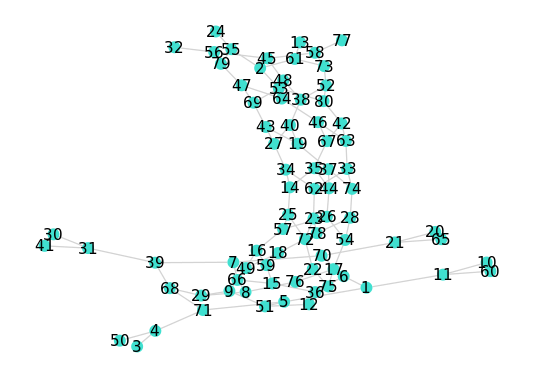

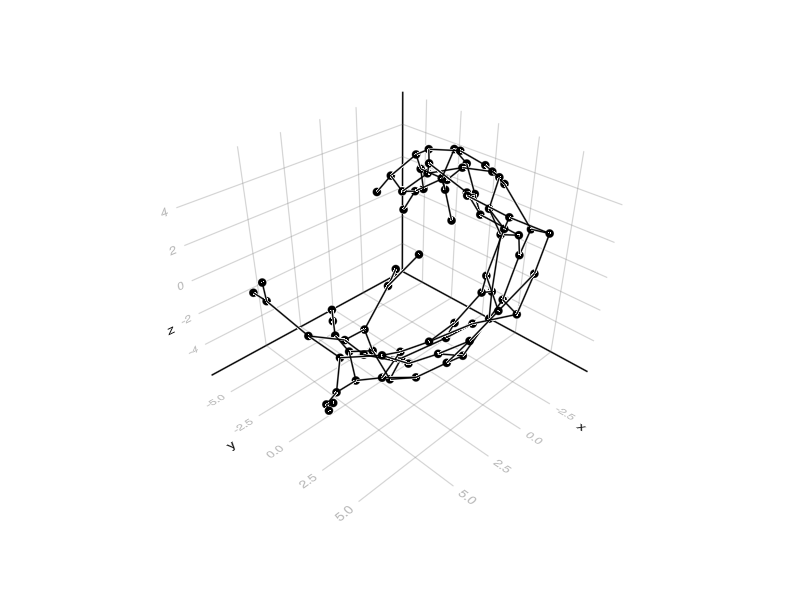

GLMakie.Screen(...)

In [64]:
function select_pairs_and_collect_unused(matrix)
    pairs = []
    used_elements = []
    list = vec(matrix)
    # Create a list of all possible indices
    indices = collect(1:length(list))
    # Shuffle the indices to ensure randomness
    shuffled_indices = shuffle(indices)

    # Iterate over shuffled indices in pairs
    for i in 1:2:length(shuffled_indices)-1
        idx1 = shuffled_indices[i]
        idx2 = shuffled_indices[i+1]
        element1 = list[idx1]
        element2 = list[idx2]
        push!(pairs, [element1, element2])
        # Store used elements to handle the odd cases
        push!(used_elements, element1)
        push!(used_elements, element2)
    end

    # Find unused elements in the original matrix
    unused_elements = setdiff(vec(matrix), used_elements)

    return pairs, unused_elements
end

function generate_random_quantum_circuit_2d_2xn(num_q_x, num_q_y, layers, theta)

    """
    Generate a random 2D quantum circuit --> num_qx,y == amount qubits in the x 
    and y directions.
    Apply nearest neighbour 2 qubit gates --> x direction and y direction in a 
    staggered fashion.
    """

    unique_symbols = [Symbol(i) for i in 1:1000]

    initial_state = [1, 0]
    tensors_in_network = []

    previous_layer_inds = Matrix{Symbol}(undef, num_q_x, num_q_y)

    # Initial state
    for i in 1:num_q_x
        for j in 1:num_q_y
            id = popfirst!(unique_symbols)
            push!(tensors_in_network, Tenet.Tensor(initial_state, [id]))
            previous_layer_inds[i,j] = id
        end
    end

    display(previous_layer_inds)
    

    for l in 1:layers

        # first type of staggered gates

        if l % 3 == 1
            pairs = []
            for j in 1:num_q_y
                if j < num_q_y
                    push!(pairs, [previous_layer_inds[1, j], previous_layer_inds[end, (j+1)]])
                else
                    push!(pairs, [previous_layer_inds[1, j], previous_layer_inds[end, 1]])
                end
            end
            datas = [xx_interaction(theta), yy_interaction(theta), zz_interaction(theta)]
            tensor_index_matrix_new = Matrix{Symbol}(undef, num_q_x, num_q_y)
            for pair in pairs
                i1 = findfirst(x -> x == pair[1], previous_layer_inds)
                i2 = findfirst(x -> x == pair[2], previous_layer_inds)
                id1 = popfirst!(unique_symbols)
                id2 = popfirst!(unique_symbols)
                push!(tensors_in_network, tq_gt(rand(datas), pair, [id1, id2]))
                tensor_index_matrix_new[i1] = id1
                tensor_index_matrix_new[i2] = id2
            end
            previous_layer_inds = tensor_index_matrix_new
        end

        if l % 3 == 2
            pairs = []
            for j in 1:num_q_y
                push!(pairs, [previous_layer_inds[1, j], previous_layer_inds[end, (j)]])
            end
            datas = [xx_interaction(theta), yy_interaction(theta), zz_interaction(theta)]
            tensor_index_matrix_new = Matrix{Symbol}(undef, num_q_x, num_q_y)
            for pair in pairs
                i1 = findfirst(x -> x == pair[1], previous_layer_inds)
                i2 = findfirst(x -> x == pair[2], previous_layer_inds)
                id1 = popfirst!(unique_symbols)
                id2 = popfirst!(unique_symbols)
                push!(tensors_in_network, tq_gt(rand(datas), pair, [id1, id2]))
                tensor_index_matrix_new[i1] = id1
                tensor_index_matrix_new[i2] = id2
            end
            previous_layer_inds = tensor_index_matrix_new
        end


        if l % 3 == 0
            pairs = []
            for j in 1:num_q_y
                if j < num_q_y
                    push!(pairs, [previous_layer_inds[1, j+1], previous_layer_inds[end, (j)]])
                else
                    push!(pairs, [previous_layer_inds[1, 1], previous_layer_inds[end, j]])
                end
            end
            datas = [xx_interaction(theta), yy_interaction(theta), zz_interaction(theta)]
            tensor_index_matrix_new = Matrix{Symbol}(undef, num_q_x, num_q_y)
            for pair in pairs
                i1 = findfirst(x -> x == pair[1], previous_layer_inds)
                i2 = findfirst(x -> x == pair[2], previous_layer_inds)
                id1 = popfirst!(unique_symbols)
                id2 = popfirst!(unique_symbols)
                push!(tensors_in_network, tq_gt(rand(datas), pair, [id1, id2]))
                tensor_index_matrix_new[i1] = id1
                tensor_index_matrix_new[i2] = id2
            end
            previous_layer_inds = tensor_index_matrix_new
        end
        
        
    end
    
    TN = Tenet.TensorNetwork(tensors_in_network)

    for tensor in Tenet.tensors(TN)
        rank = length(inds(tensor))
        if rank > 3 #remove the bulk tesnors and replace them with new QR  tensors
            pop!(TN, tensor)
            Q, R = LinearAlgebra.qr(tensor, left_inds=inds(tensor)[1:2])
            push!(TN, Q)
            push!(TN, R)
        end
    
    end
    

    return TN

end


tn1 = generate_random_quantum_circuit_2d_2xn(2, 4, 9, 1)


g, tv_map, ie_map, weighted, ei_map = extract_graph_representation(tn1)
println("#amount of tensors= ", nv(g), "amount of indices =" , length(edges(g)))
println("amount of loops = ", length(minimum_cycle_basis(g)))
display(gplot(g, nodelabel=[i for i in 1:nv(g)], layout=spring_layout))



using GLMakie, GraphMakie
using GraphMakie.NetworkLayout

display(GraphMakie.graphplot(g; layout=SFDP(; dim=3 )))



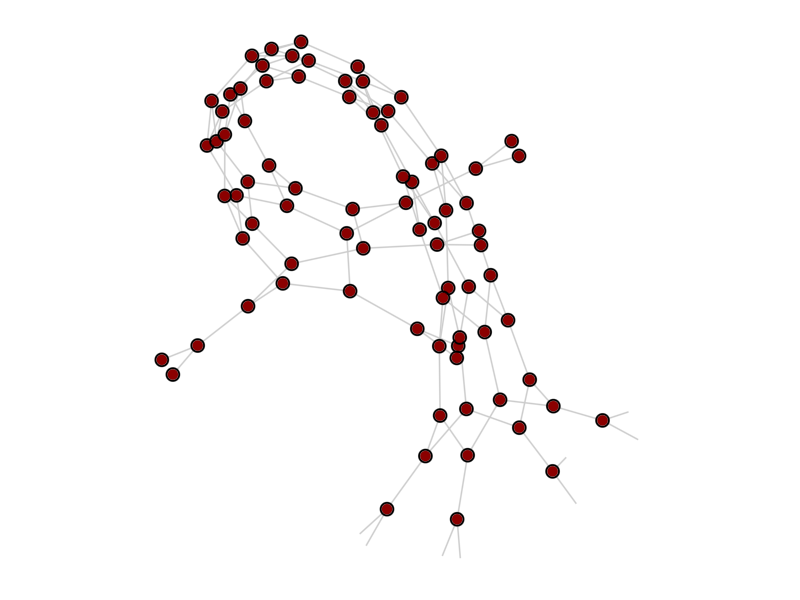

(2, 2, 2, 2, 2, 2, 2, 2)


In [65]:
drawing1 = Makie.plot(tn1, node_color=[:darkred for i in 1:length(tensors(tn1))], layout=Spring(), edge_color=:grey80)
display(drawing1)
println(size(Tenet.contract(tn1)))